# Custom LSTM cell with probabilistic activation functions

In [1]:
'''
This one is the child of prob_cognition01.
I removed the non-probabilistic models because the use of JIT requires to restart the kernel
each time a csipt is changed. And it was annoying to wait for all the models to execute!
''';

### Imports

In [2]:
%load_ext line_profiler

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

### Define general variables 

In [3]:
#proportion of data used for training
prop_train = 2/3

### Fetch data 

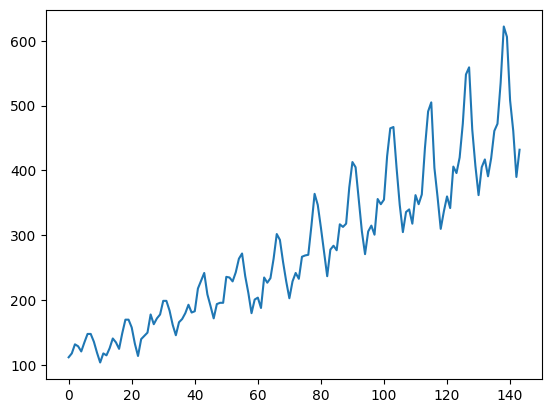

In [4]:
data_folder = './data/'
data_file = 'airline_passengers.csv'

df = pd.read_csv(data_folder + data_file)
time_series = df[["Passengers"]].values.astype('float32')

# see how data looks like and whether it makes sense
plt.plot(time_series)
plt.show()

In [5]:
# train-test split the time series
train_size = int(len(time_series) * prop_train)
test_size = len(time_series) - train_size
train, test = time_series[:train_size], time_series[train_size:]

In [6]:
# create a function to generate a dataset of fixed window from a time series
lookback = 4
def create_dataset(dataset, lookback):
    '''
    Transforms a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    '''
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        #target = dataset[i+lookback]
        #y.append([target])
        X.append(feature)
        y.append(target)
    #return torch.tensor(X), torch.tensor(y)
    return torch.tensor(X).to(device), torch.tensor(y).to(device)

In [7]:
# create_dataset is designed to convert a time series into a tensor of dimensions: 
# (window sample, time steps, features)
# window_sample = number of sub-serie; time steps = length of sub-serie
# ergo: window_sample = len(data set) - lookback; time_steps = lookback

X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(train.ndim)
print(len(train),len(train[0]))
print(X_train[:5])

torch.Size([92, 4, 1]) torch.Size([92, 4, 1])
torch.Size([44, 4, 1]) torch.Size([44, 4, 1])
2
96 1
tensor([[[112.],
         [118.],
         [132.],
         [129.]],

        [[118.],
         [132.],
         [129.],
         [121.]],

        [[132.],
         [129.],
         [121.],
         [135.]],

        [[129.],
         [121.],
         [135.],
         [148.]],

        [[121.],
         [135.],
         [148.],
         [148.]]], device='cuda:0')


/tmp/ipykernel_10842/563140132.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(X).to(device), torch.tensor(y).to(device)


## Probabilistic LSTM 

### Import the custom LSTM and probabilistic activation 

In [8]:
from models import custom_lstms, ProbAct

/home/gabrielmadirolas/pytorch_env/pytorch_env/lib/python3.12/site-packages/torch/jit/_recursive.py:313: UserWarning: 'layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn(
/home/gabrielmadirolas/pytorch_env/pytorch_env/lib/python3.12/site-packages/torch/jit/_recursive.py:313: UserWarning: 'directions' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn(


### Define variables 

In [49]:
# number of LSTM layers CORRECT THIS to be introduced in the num_layers variable of nn.LSTM

input_size = 1 # number of features
hidden_size = 50
n_LSTM = 1
dropout = 0.0 #False #0.5
batch_first = True

lr = 0.001 # Gab: was 0.01

init_params = {
'mean_mu':0.0,
'std_mu':0.0,
'mean_sigma':0.0,
'std_sigma':0.0,
# to use a sigmoid for sigma, set the two following to diffrent than 0.0
# Both are set as non-trainable in the probact.py file
'alpha':0.0, # must not be integer
'beta':0.0 # must not be integer
}
'''
if not os.path.exists('checkpoint'): # Gab: added this two lines
    os.mkdir('checkpoint')
resume = False
''';

### Define model

In [50]:
# Build the LSTM model to predict the time series. With lookback=1, accuracy won't be great
# The model is created as a class, with a LSTM layer and a fully-connected layer


class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        #self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=n_LSTM, batch_first=True) # I think input_size is the number of features
        #self.lstm = LSTMCell(input_size=input_size, hidden_size=hidden_size, num_layers=n_LSTM, dropout=dropout) # , batch_first=True) # I think input_size is the number of features
        self.lstm = custom_lstms.prob_lstm(input_size=input_size, hidden_size=hidden_size, num_layers=n_LSTM, 
                     bias=True, bidirectional=False, dropout=dropout, batch_first=batch_first)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        x, states = self.lstm(x) 
        x = self.linear(x)
        return x # remeber that the prediction is the last time step of this output
'''The output of nn.LSTM() is a tuple. The first element is the generated hidden states [from the last LSTM layer],
one for each time step of the input. 
The second element is the LSTM cell’s memory and hidden states [for all LSTM layers], which is not used here. 
''';

In [51]:
test_model = AirModel()
print(test_model.lstm)
print(test_model.linear)

dropout 0.0
MyStackedLSTMWithDropout(
  (layers): RecursiveScriptModule(
    original_name=ModuleList
    (0): LSTMLayer(
      (cell): ProbLSTMCell(
        (sigma): RecursiveScriptModule(original_name=EWTrainableMuSigma)
      )
    )
  )
  (dropout_layer): RecursiveScriptModule(original_name=Dropout)
)
Linear(in_features=50, out_features=1, bias=True)


### Train the LSTM network

In [52]:
'''
Because it is a regression problem, MSE is chosen as the loss function.
PyTorch tensors will be combined into a dataset using torch.utils.data.TensorDataset
Batch for training is provided by a DataLoader
'''

#torch.backends.cudnn.benchmark = True

model = AirModel()
optimizer = optim.Adam(model.parameters(),lr=lr)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu') # for tests
model.to(device)

start_time = time.time()

print('lr',lr)
n_epochs = 2000 # was 2000
for epoch in range(n_epochs+1):
    model.train()
    for X_batch, y_batch in loader:
        X_batch = X_batch#.to(device)
        y_batch = y_batch#.to(device)
        y_pred = model(X_batch)
        y_pred = torch.swapaxes(y_pred,0,1) # prob_lstm is returning batch second
        #print('X_batch',X_batch.size())
        #print('y_batch',y_batch.size())
        #print('y_pred',y_pred.size())
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        X_train = X_train#.to(device)
        y_train = y_train#.to(device)
        y_pred = model(X_train)
        y_pred = torch.swapaxes(y_pred,0,1) # prob_lstm is returning batch second
        #print('X_train',X_train.size())
        #print('y_train',y_train.size())
        #print('y_pred',y_pred.size())
        train_rmse = np.sqrt(loss_fn(y_pred, y_train).cpu())
        X_test = X_test#.to(device)
        y_test = y_test#.to(device)
        y_pred = model(X_test)
        y_pred = torch.swapaxes(y_pred,0,1) # prob_lstm is returning batch second
        test_rmse = np.sqrt(loss_fn(y_pred, y_test).cpu())
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    
#print('X_train[:2]',X_train[:2])
print("--- %s seconds ---" % (time.time() - start_time))

dropout 0.0
lr 0.001
Epoch 0: train RMSE 226.5679, test RMSE 425.8090
Epoch 100: train RMSE 210.8423, test RMSE 409.4930
Epoch 200: train RMSE 194.7142, test RMSE 392.6114
Epoch 300: train RMSE 179.1423, test RMSE 376.1334
Epoch 400: train RMSE 164.2384, test RMSE 360.1371
Epoch 500: train RMSE 149.9091, test RMSE 344.4670
Epoch 600: train RMSE 136.1983, test RMSE 329.0895
Epoch 700: train RMSE 123.2313, test RMSE 314.0302
Epoch 800: train RMSE 111.2268, test RMSE 299.3894
Epoch 900: train RMSE 100.1665, test RMSE 285.1545
Epoch 1000: train RMSE 90.0460, test RMSE 271.2435
Epoch 1100: train RMSE 81.0207, test RMSE 257.8884
Epoch 1200: train RMSE 73.2876, test RMSE 245.1122
Epoch 1300: train RMSE 67.1115, test RMSE 233.2622
Epoch 1400: train RMSE 61.9656, test RMSE 222.2402
Epoch 1500: train RMSE 58.1068, test RMSE 212.2767
Epoch 1600: train RMSE 55.7807, test RMSE 203.8867
Epoch 1700: train RMSE 54.5339, test RMSE 197.6251
Epoch 1800: train RMSE 53.8217, test RMSE 193.1011
Epoch 1900: 

KeyboardInterrupt: 

### Verify the network

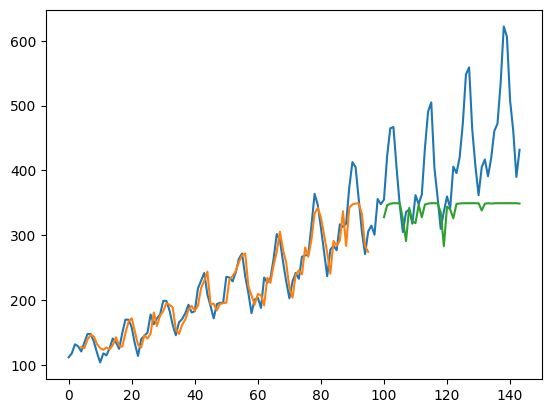

In [13]:
'''
It is expected to see the RMSE of test set is an order of magnitude larger. 
The RMSE of 100 means the prediction and the actual target would be
in average off by 100 in value (i.e., 100,000 passengers in this dataset).
To better understand the prediction quality, let's plot the output using matplotlib
'''
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(time_series) * np.nan
    # y_pred = model(X_train) # redundant line in the tutorial
    # y_pred = y_pred[:, -1, :] # redundant line in the tutorial 
    train_plot[lookback:train_size] = model(X_train)[-1, :, :].cpu() # remember that prob_lstm returns batch second
    # shift test predictions for plotting
    test_plot = np.ones_like(time_series) * np.nan
    test_plot[train_size+lookback:len(time_series)] = model(X_test)[-1, :, :].cpu() # remember that prob_lstm returns batch second
# plot
plt.plot(time_series)
plt.plot(train_plot) # ugly colors in the tutorial: , c='r')
plt.plot(test_plot) # ugly colors in the tutorial: , c='g')
plt.show()

In [14]:
t = torch.empty(3, 5, 2)
ts = t.size()
print(ts)
print(ts[2])

batch, seq_len, input_size = ts[:]
print(batch, seq_len, input_size)

torch.Size([3, 5, 2])
2
3 5 2


In [15]:
batch_first = torch.tensor([[[0,1],[2,3],[4,5],[6,7],[8,9]],[[10,11],[12,13],[14,15],[16,17],[18,19]],[[20,21],[22,23],[24,25],[26,27],[28,29]]])
print(batch_first.size())
batch_second = torch.swapaxes(batch_first,0,1)
print(batch_second.size())
print(batch_second)

torch.Size([3, 5, 2])
torch.Size([5, 3, 2])
tensor([[[ 0,  1],
         [10, 11],
         [20, 21]],

        [[ 2,  3],
         [12, 13],
         [22, 23]],

        [[ 4,  5],
         [14, 15],
         [24, 25]],

        [[ 6,  7],
         [16, 17],
         [26, 27]],

        [[ 8,  9],
         [18, 19],
         [28, 29]]])


In [16]:
4 + 10 % 2

4